# **Federated Learning model**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Design of MLP

In [ ]:

class BankDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)  # Convert DataFrame to tensor
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # Convert pd.Series to numpy.ndarray and then to tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# PyTorch Model
class MLP(nn.Module): # 3 layers model
    def __init__(self, input_size, dropout_prob=0.2, l2_reg=0.001):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(dropout_prob)

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(dropout_prob)

        self.fc3 = nn.Linear(32, 1)

        self.l2_reg = l2_reg
        self.best_loss = float('inf')
        self.patience = 5
        self.current_patience = 0

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x
    
    # prevent overfitting
    def l2_regularization(self):
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2) ** 2
        return self.l2_reg * l2_loss

    # Early stop to prevent overfitting
    def early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.current_patience = 0
        else:
            self.current_patience += 1
            if self.current_patience >= self.patience:
                return True
        return False

In [ ]:
# Focal loss function. It can solve the problem of uneven data labels by adjusting
# the weight of cross entropy loss to focus on the samples that are difficult to classify
class FocalLoss(nn.Module):
    def __init__(self, alpha=30, gamma=1.5, logits=True, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        
        # Focal Loss function definition 
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss


In [ ]:
# Prediction every fold
def predict_fold(model, test_loader):
    fold_true_labels = []
    fold_predictions = []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Use signmoid to predict the final results
            outputs = torch.sigmoid(outputs)  
            predicted = (outputs > 0.5).int().view(-1)  # Binary Catagory
            fold_true_labels.extend(labels.cpu().numpy())
            fold_predictions.extend(predicted.cpu().numpy())

    return fold_true_labels, fold_predictions

# Two type of Evaluation function, weighted average aims to focus on both 0 and 1 type
def weighted_evaluate_fold(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# binary average aims to focus on type 1
def binary_evaluate_fold(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    return accuracy, precision, recall, f1

## Federated core functions

In [ ]:
# Train the model locally
def train_local_model(local_model, criterion, optimizer, scheduler, local_train_loader, local_test_loader, num_epochs):
    losses = []
    val_losses = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    local_model.to(device)
    for epoch in range(num_epochs):
        local_model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(local_train_loader): # each local model training process
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = local_model(inputs)
            loss = criterion(outputs, labels) + local_model.l2_regularization()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # learning rate scheduler
        scheduler.step()
        train_loss = running_loss / len(local_train_loader)
        losses.append(train_loss)

        # evaluation in each local model
        local_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in local_test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = local_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(local_test_loader)
        val_losses.append(val_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if local_model.early_stop(val_loss):
            break

    return local_model, losses, val_losses

# Collect all the local models and adveraging with correspongding weights
def federated_average(global_model, local_models, local_data_sizes, total_data_size):
    for key in global_model.state_dict().keys():
        if global_model.state_dict()[key].dtype == torch.float32:
            global_model.state_dict()[key].zero_()
            for i, local_model in enumerate(local_models):# weighted parameters
                global_model.state_dict()[key] += local_model.state_dict()[key] * (local_data_sizes[i] / float(total_data_size))
    return global_model

In [ ]:

# Loading data for three banks
data1 = pd.read_csv('../data/bank1_New.csv')
data2 = pd.read_csv('../data/bank2_New.csv')
data3 = pd.read_csv('../data/bank3_New.csv')

# data1 = pd.read_csv('bank1_New.csv')
# data2 = pd.read_csv('bank2_New.csv')
# data3 = pd.read_csv('bank3_New.csv')


bank_data = [data1, data2, data3]
# for calculating federated weight
local_data_sizes = [len(bank_data[0]), len(bank_data[1]), len(bank_data[2])]
total_data_size = sum(local_data_sizes)

# Preprocessing data
for i in range(len(bank_data)):
    X = bank_data[i].iloc[:, :-1]
    y = bank_data[i].iloc[:, -1]

    # Data preprocess
    scaler = MinMaxScaler()
    X_normalized = X.iloc[:, :-1]
    X_normalized = scaler.fit_transform(X_normalized)
    X_normalized = pd.DataFrame(X_normalized, columns=X.columns[:-1])
    X_normalized["L-3"] = X.iloc[:, -2]

    # split the data and create loaders, reserver 20% of data for testing
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=63)
    train_dataset = BankDataset(X_train, y_train)
    test_dataset = BankDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    bank_data[i] = (train_loader, test_loader)

input_size = X.shape[1]
global_model = MLP(input_size)
num_global_epochs = 5
num_local_epochs = 10

for global_epoch in range(num_global_epochs):
    print(f"Global Epoch {global_epoch + 1}")

    # Collection of local models
    local_models = []
    for i in range(len(bank_data)):
        print(f"Training local model for Bank {i + 1}")

        # Global model distribution
        local_model = copy.deepcopy(global_model)

        # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        criterion = FocalLoss(alpha=30, gamma=1.5, logits=True, reduction="mean")
        optimizer = torch.optim.Adam(local_model.parameters(), lr=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        # Each bank load corresponding datas
        local_train_loader, local_test_loader = bank_data[i]
        local_model, losses, val_losses = train_local_model(local_model, criterion, optimizer, scheduler, local_train_loader, local_test_loader, num_local_epochs)
        local_models.append(local_model)

    # Federated averaging
    global_model = federated_average(global_model, local_models, local_data_sizes, total_data_size)

# Collect test datasets from all banks
all_test_datasets = []
for i in range(len(bank_data)):
    _, local_test_loader = bank_data[i]
    all_test_datasets.append(local_test_loader.dataset)

# Concatenate test datasets into a single DataLoader
all_test_loader = torch.utils.data.ConcatDataset(all_test_datasets)
all_test_loader = DataLoader(all_test_loader, batch_size=32, shuffle=False)

# Evaluate the global model on the test data
global_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model.to(device)

y_true, y_pred = predict_fold(global_model, all_test_loader)
accuracy1, precision1, recall1, f11 = weighted_evaluate_fold(y_true, y_pred)
accuracy2, precision2, recall2, f12 = binary_evaluate_fold(y_true, y_pred)

# Two type of evaluation average, in our task we use the binary one.
print(f"Global Model Weighted average Evaluation:\nAccuracy: {accuracy1}\nPrecision: {precision1}\nRecall: {recall1}\nF1 Score: {f11}")
print(f"Global Model Binary average Evaluation:\nAccuracy: {accuracy2}\nPrecision: {precision2}\nRecall: {recall2}\nF1 Score: {f12}")


Global Epoch 1
Training local model for Bank 1
Epoch [1/10], Loss: 17.3792, Val Loss: 13.1586
Epoch [2/10], Loss: 15.2418, Val Loss: 12.7209
Epoch [3/10], Loss: 13.6451, Val Loss: 11.5514
Epoch [4/10], Loss: 12.5863, Val Loss: 10.7983
Epoch [5/10], Loss: 11.3779, Val Loss: 10.0421
Epoch [6/10], Loss: 10.6051, Val Loss: 9.1297
Epoch [7/10], Loss: 9.9457, Val Loss: 8.6463
Epoch [8/10], Loss: 9.1126, Val Loss: 8.0196
Epoch [9/10], Loss: 8.5122, Val Loss: 7.4906
Epoch [10/10], Loss: 8.0778, Val Loss: 7.1314
Training local model for Bank 2
Epoch [1/10], Loss: 15.0004, Val Loss: 11.4686
Epoch [2/10], Loss: 11.5540, Val Loss: 9.2459
Epoch [3/10], Loss: 9.4730, Val Loss: 7.7738
Epoch [4/10], Loss: 8.1233, Val Loss: 6.7444
Epoch [5/10], Loss: 7.1462, Val Loss: 6.0115
Epoch [6/10], Loss: 6.3653, Val Loss: 5.3814
Epoch [7/10], Loss: 5.7725, Val Loss: 4.9635
Epoch [8/10], Loss: 5.4980, Val Loss: 4.5751
Epoch [9/10], Loss: 5.0537, Val Loss: 4.3602
Epoch [10/10], Loss: 4.9619, Val Loss: 4.0896
Train

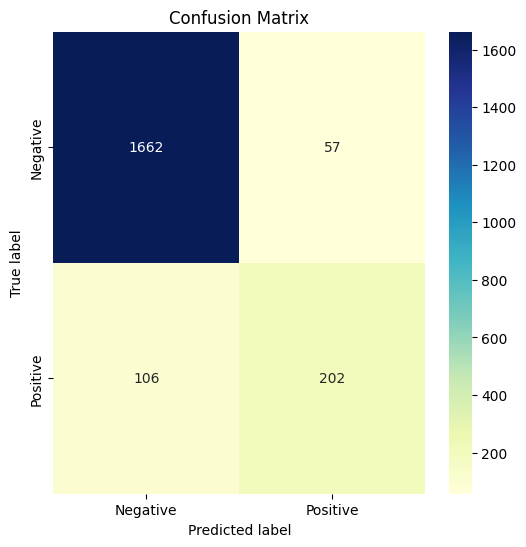

In [ ]:
import seaborn as sns

# Calculate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
